# Pretrain deep learning

In [471]:
!nvidia-smi

Tue Dec 20 22:38:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 527.56       Driver Version: 527.56       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   44C    P8    35W / 240W |   6861MiB /  8192MiB |     18%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [472]:
import numpy as np
import matplotlib.pyplot as plt

def readBinDataset(filename):
    binDataset = np.load(filename)
    #print(bin)

    return binDataset

In [473]:
sequence = 7

In [474]:
#windows
binDataset=readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence)

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [475]:
binDataset=binDataset.reshape((len(binDataset), 3601,1 ))

In [476]:
binDataset = np.array([ consec_frames for consec_frames in zip(binDataset[0::], binDataset[1::])])

In [477]:
binDataset[0][0], binDataset[0][1]

(array([[31.20101302],
        [31.20506603],
        [ 0.        ],
        ...,
        [26.86569695],
        [26.93322091],
        [ 0.        ]]),
 array([[32.08700149],
        [32.03307136],
        [ 0.        ],
        ...,
        [31.12350481],
        [ 0.        ],
        [32.17710465]]))

In [478]:
binDataset.shape

(1100, 2, 3601, 1)

In [479]:
plt.rcParams["figure.figsize"] = (15,5.5)

In [480]:
binDataset[0].shape

(2, 3601, 1)

In [481]:
# windows
posePath = "D:\\Ara\\poses\\"
# linux
# posePath = "/mnt/d/Ara/poses/"
poseIdx = "%02d" % sequence
pose = poseIdx + ".txt"

In [482]:
filePath = posePath+pose
file = open(filePath,'r')

In [483]:
def isRotationMatrix(R):
    Rt = np.transpose(R)
    shouldBeIdentity = np.dot(Rt, R)
    I = np.identity(3, dtype=R.dtype)
    n = np.linalg.norm(I - shouldBeIdentity)
    return n < 1e-6

In [484]:
import math
# from scipy.spatial.transform import Rotation as R

def rotationMatrixToEulerAngles(R):
    assert (isRotationMatrix(R))
    sy = math.sqrt(R[0, 0] * R[0, 0] + R[1, 0] * R[1, 0])
    singular = sy < 1e-6

    if not singular:
        x = math.atan2(R[2, 1], R[2, 2])
        y = math.atan2(-R[2, 0], sy)
        z = math.atan2(R[1, 0], R[0, 0])
    else:
        x = math.atan2(-R[1, 2], R[1, 1])
        y = math.atan2(-R[2, 0], sy)
        z = 0

    return np.array([x, y, z])
    r = R.from_matrix(RMat)
    return r.as_euler('xyz')


In [485]:
def get6DoFPose(line):
    rotationTranslation = line.split()
    #print(rotationTranslation)
    
    
    homogenousCoord = np.array(rotationTranslation, dtype=np.float64).reshape((3,4))
    homogenousCoord = np.append(homogenousCoord, [[0,0,0,1]], axis=0)

    #print(homogenousCoord)
    R = homogenousCoord[0:3,0:3]
    pos = homogenousCoord[0:3,3]
    #print(R , pos)
    
    # assert(1==3)

    
    angles = rotationMatrixToEulerAngles(R)

    return np.concatenate((pos, angles)), homogenousCoord

In [486]:
import pykitti
import numpy as np
import math 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R

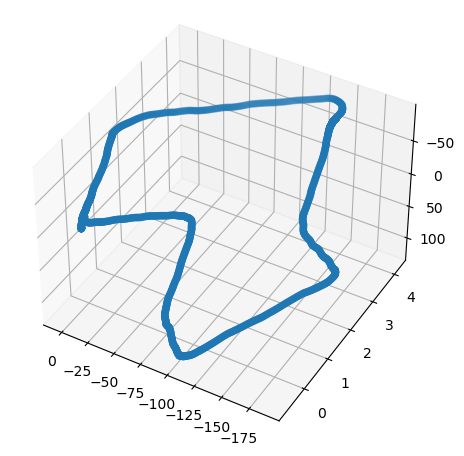

In [487]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x=np.array([])
y=np.array([])
z=np.array([])
yaw=np.array([])

basedir = 'D:\\dataset\\'
sequence_ = '%02d' % sequence
dataset = pykitti.odometry(basedir, sequence_)
for i in range(len(dataset.poses)):
    x=np.append(x,[dataset.poses[i][0][3]])
    y=np.append(y,[dataset.poses[i][1][3]])
    z=np.append(z,[dataset.poses[i][2][3]])

ax.scatter(x, y, z, marker='o')

t_xyz = np.c_[x,y,z]
ax.view_init(-140, 60)

plt.show()

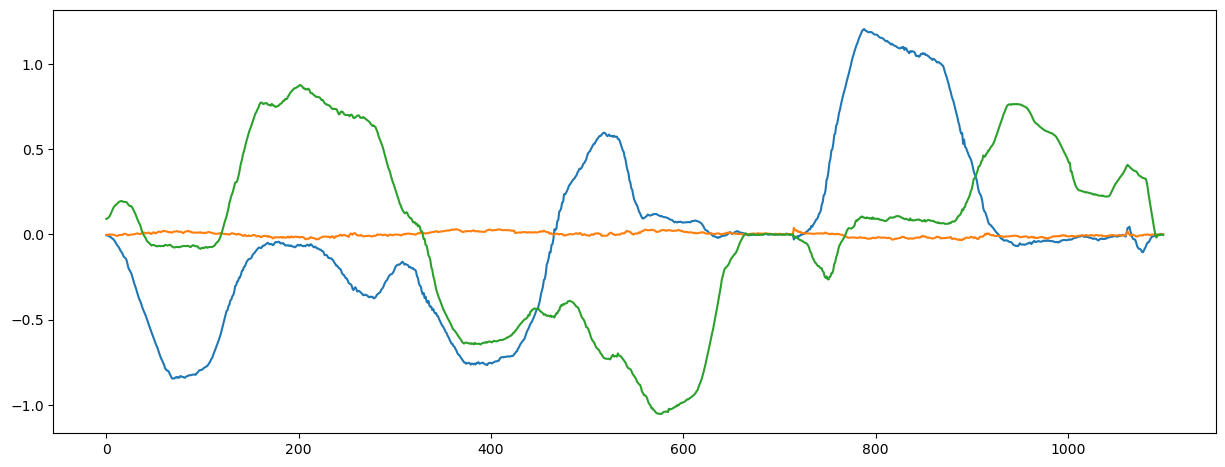

In [488]:
dt_xyz = t_xyz[1:] - t_xyz[0:-1]
plt.plot(dt_xyz)

In [489]:
dt_xz = dt_xyz[:,[0,2]]

0.6312571292033071

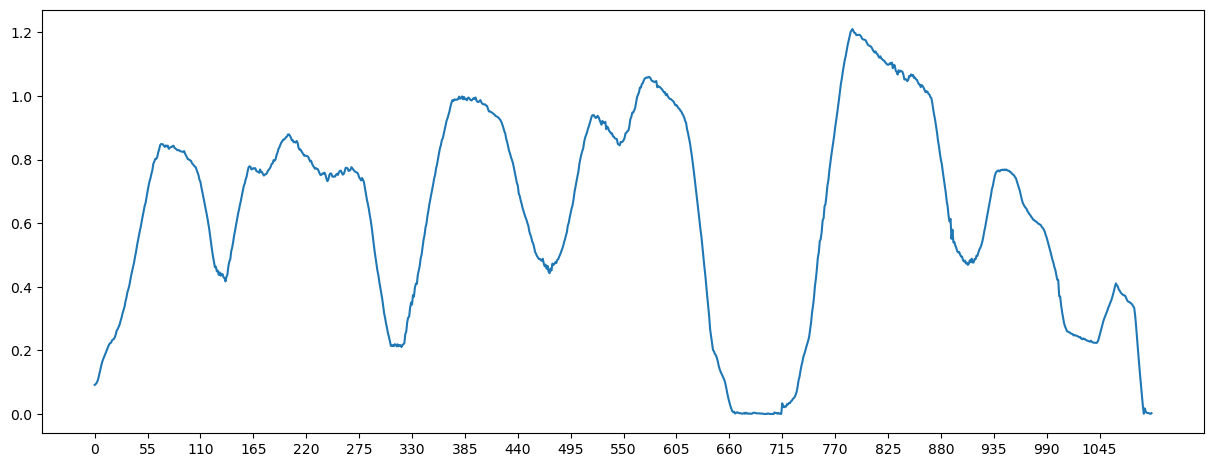

In [490]:
translation = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)
plt.xticks(range(0, len(translation),int(len(translation)/20)))
plt.plot(translation)
np.mean(translation)

In [491]:
# translation = translation + 0.28

In [492]:
# plt.xticks(range(0, len(translation),int(len(translation)/20)))
# plt.plot(translation)
# np.mean(translation)

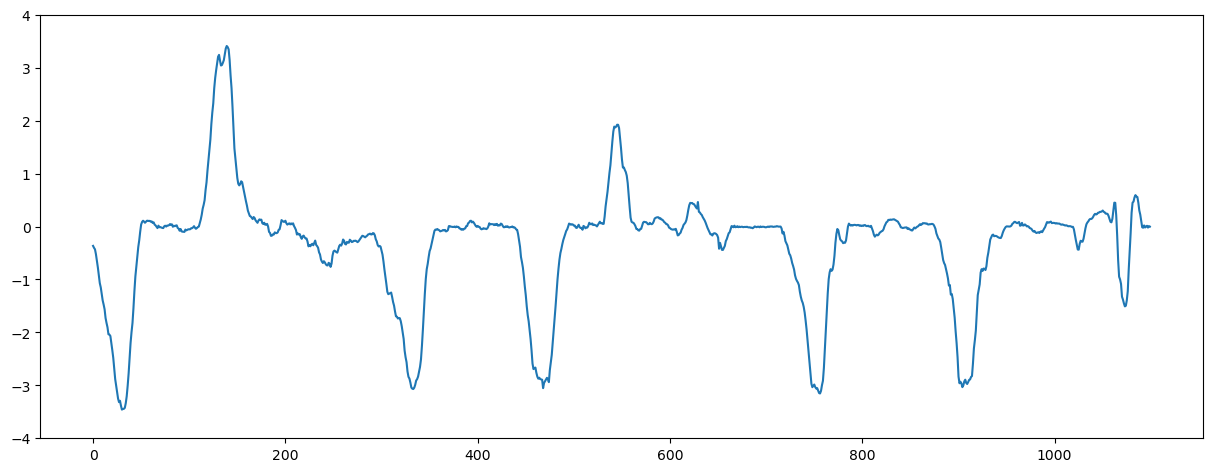

In [493]:
fig1 = plt.figure()
# arrow = plt.axes()
yaw_=np.zeros(len(dataset.poses))
for i in range(len(dataset.poses)):
    r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
    yaw=-r.as_rotvec()[1]
    yaw_[i]=yaw
    # arrow.arrow(x[i], y[i], math.sin(yaw), math.cos(yaw), head_width=0.05, head_length=0.1, fc='k', ec='k')
# plt.plot(np.rad2deg(yaw_))

diff_pitch = (yaw_[1::]-yaw_[:-1:])

# outlier detection
idxs = np.where((diff_pitch>np.deg2rad(300)) | (diff_pitch<np.deg2rad(-300)))

diff_pitch[idxs] =  diff_pitch[idxs] - np.deg2rad(360)  * np.sign(diff_pitch[idxs])

diff_pitch = -diff_pitch
plt.plot((np.rad2deg(diff_pitch)))
plt.ylim([-4, 4])
plt.show()

In [494]:
# len(t_xyz) , len(yaw)

label = np.array((translation,diff_pitch))
label = label.transpose()
binDataset.shape, label.shape

((1100, 2, 3601, 1), (1100, 2))

In [495]:
from sklearn.preprocessing import MinMaxScaler

In [496]:
scaler = MinMaxScaler()
scaler.fit(label)

MinMaxScaler()

In [497]:
scaler.data_max_, scaler.data_min_

(array([1.21078317, 0.05951962]), array([ 0.00018   , -0.06035576]))

In [498]:
label = scaler.transform(label)

In [499]:
np.mean(translation)/np.mean(diff_pitch)

-107.31420219561268

In [500]:
sample_sz = 21
t_bin = np.zeros(sample_sz)
r_bin = np.zeros(sample_sz)

interval = 20

t_bin = np.zeros(sample_sz)
r_bin = np.zeros(sample_sz)
labelBinned = np.array([[t_bin,r_bin]])
for data in label:
    t_bin = np.zeros(sample_sz)
    r_bin = np.zeros(sample_sz)
    t_bin[int(((data[0]*interval)))] = 1
    r_bin[int(((data[1]*interval)))] = 1
    
    labelBinned = np.concatenate([labelBinned, np.array([np.array([t_bin, r_bin])])], axis=0)


In [501]:
labelBinned = labelBinned[1:]

In [502]:
labelBinned[0][0]

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.])

In [503]:
label[0]

array([0.07556405, 0.45026158])

In [504]:
labelBinned.shape, label.shape

((1100, 2, 21), (1100, 2))

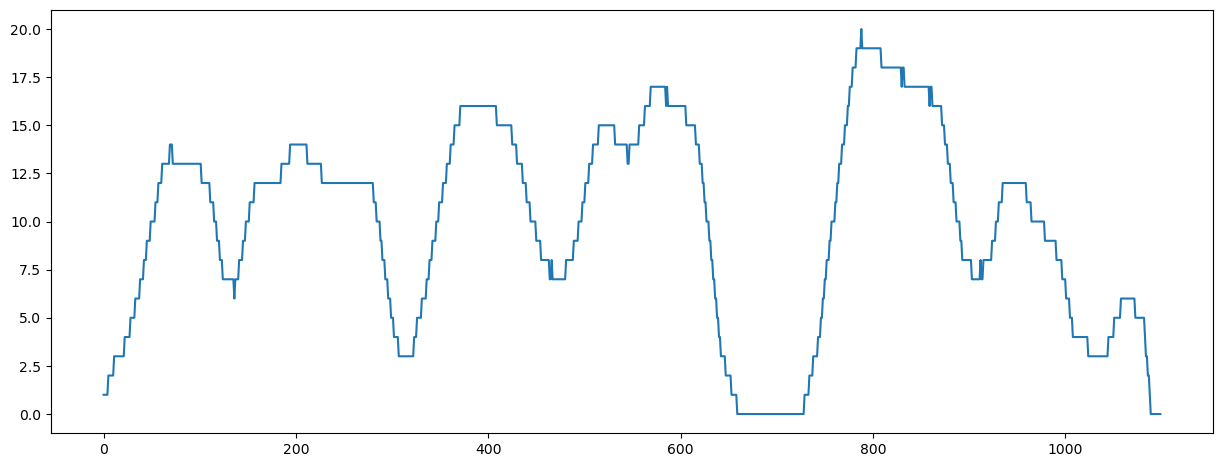

In [505]:
np.where(labelBinned[:,0] > 0)[1]
plt.plot(np.where(labelBinned[:,0] > 0)[1])

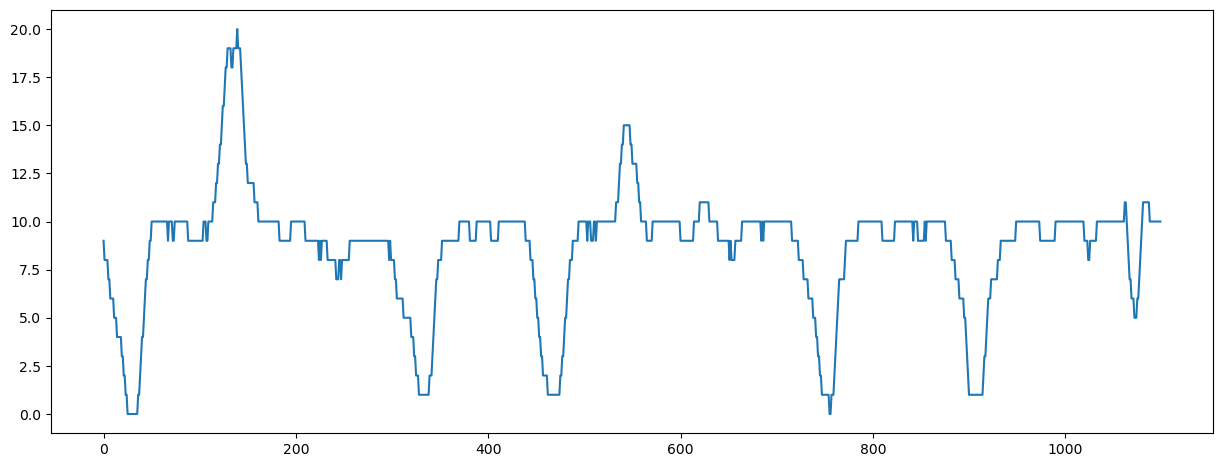

In [506]:
np.where(labelBinned[:,1] > 0)[1].shape
plt.plot(np.where(labelBinned[:,1] > 0)[1])

In [507]:
import tensorflow as tf

In [633]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM

In [634]:
binDataset.shape , label.shape, labelBinned.shape

AttributeError: 'dict' object has no attribute 'shape'

In [635]:
# labelBinned = labelBinned.reshape((1100,3601,2))

In [636]:

# with tf.device('/device:GPU:0'):
dataset = tf.data.Dataset.from_tensor_slices((binDataset,{"translation": labelBinned[:,0], "rotation" : labelBinned[:,1] } ))
# tf.compat.v1.disable_eager_execution()
# data = (binDataset,label)
# a = tf.compat.v1.placeholder(tf.float32,shape=binDataset.shape)
# dataset = tf.data.Dataset.from_tensor_slices(a)
# dataset = dataset.prefetch(buffer_size=1000)
# dataset = dataset.batch(128)
# iterator = tf.compat.v1.data.make_initializable_iterator(dataset)
# next_batch = iterator.get_next()
# with tf.compat.v1.Session() as sess:
#     sess.run(iterator.initializer, feed_dict={a: binDataset})

In [637]:
DATASET_SIZE = len(dataset)
DATASET_SIZE

1100

In [638]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)
#.batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
full_dataset = dataset.shuffle(buffer_size=100).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = full_dataset.take(train_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = full_dataset.skip(train_size).prefetch(buffer_size=tf.data.AUTOTUNE)
val_data = test_data.skip(test_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.take(test_size).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [639]:
train_data, val_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None)})>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None)})>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None)})>)

In [640]:
train_one_sample=train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, 2, 3601, 1), dtype=tf.float64, name=None), {'translation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None), 'rotation': TensorSpec(shape=(None, 21), dtype=tf.float64, name=None)})>

In [641]:
for datum, label in train_one_sample:
  print(f"""
  bin data : {datum}
  bin shape: {datum.shape}
  bin dtype: {datum.dtype}
  translation : {np.where(label['translation'] > 0)[1]}
  rotation : {np.where(label['rotation'] > 0)[1]}
        """)


  bin data : [[[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]


 [[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]


 [[[10.15295726]
   [ 7.83690161]
   [ 0.        ]
   ...
   [ 0.        ]
   [10.22935445]
   [10.06710385]]

  [[ 9.61301277]
   [ 9.62092591]
   [ 9.6289196 ]
   ...
   [ 9.62146537]
   [ 0.        ]
   [ 9.60119197]]]


 ...


 [[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]]


 [[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   ...
   [ 0.        ]
   [ 0. 

# CNN Model Creation

In [649]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model = Sequential([
  Conv1D(filters=32, 
                         kernel_size=3, # can also be (3, 3)
                         strides=1,
                         activation="relu",
                         padding="same",
                         input_shape=(2, 3601, 1), name="Conv1"), # first layer specifies input shape (height, width, colour channels)
  Conv1D(32, 3, 2,  padding="same",activation="relu", name="Conv2"),
    
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool"),
  Conv1D(64, 3, 1,  padding="same",activation="relu", name="Conv3"),
  Conv1D(64, 3, 2,  padding="same",activation="relu", name="Conv4"),
  
  AveragePooling2D(pool_size=(1,3),
                                     strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool2"),
  
  Conv1D(128, 3, 1,  padding="same",activation="relu", name="Conv5"),
  Conv1D(128, 3, 2,  padding="same",activation="relu", name="Conv6"),

  AveragePooling2D(pool_size=(1,3),strides=(1,3),data_format='channels_last', padding='valid', name="AvgPool3"),
  
    Flatten(),
  ])

In [650]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv1D)              (None, 2, 3601, 32)       128       
                                                                 
 Conv2 (Conv1D)              (None, 2, 1801, 32)       3104      
                                                                 
 AvgPool (AveragePooling2D)  (None, 2, 600, 32)        0         
                                                                 
 Conv3 (Conv1D)              (None, 2, 600, 64)        6208      
                                                                 
 Conv4 (Conv1D)              (None, 2, 300, 64)        12352     
                                                                 
 AvgPool2 (AveragePooling2D)  (None, 2, 100, 64)       0         
                                                                 
 Conv5 (Conv1D)              (None, 2, 100, 128)     

In [651]:
input_layer = tf.keras.layers.Input(shape=(None,2,3601,1), ragged=True)
cnn_model = model
# for layer in model.layers:
#     layer._inbound_nodes = []
#     cnn_model = layer(cnn_model)

In [653]:
cnn_model = TimeDistributed(cnn_model)(input_layer)

In [654]:
cnn_model = LSTM(1024,return_sequences=True)(cnn_model)

In [655]:
cnn_model = LSTM(1024, return_sequences=True)(cnn_model)

In [656]:
model1 = Dense(512, activation='relu')(cnn_model)
model2 = Dense(512, activation='relu')(cnn_model)

model1 = Dropout(0.3) (model1)
model2 = Dropout(0.3) (model2)


model1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
model2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

model1 = Dropout(0.2) (model1)
model2 = Dropout(0.2) (model2)

# model1 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model1)
# model2 = tf.keras.layers.Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(1e-3))(model2)

# model1 = tf.keras.layers.Dropout(0.2) (model1)
# model2 = tf.keras.layers.Dropout(0.2) (model2)

model1 = Dense(21, name="translation",activation='softmax')(model1) # translate
model2 = Dense(21, name="rotation",activation='softmax')(model2) # yaw

# model1 = tf.keras.layers.Activation('softmax', name="translation")(model1)
# model2 = tf.keras.layers.Activation('softmax', name="rotation")(model2)

pre_model = tf.keras.Model(inputs=[input_layer], outputs=[model1, model2])
# losses = {
# 	"translation": CustomAccuracyTranslation(),
# 	"rotation": CustomAccuracyRotation(),
# }
# # losses = {"translation" : "mse", "rotation" : "mse"}
# loss_weights = {'translation' : 1, 'rotation' : 150}
# pre_model.compile(optimizer='adam',  loss=losses,loss_weights=loss_weights, metrics={"translation": ["mse"], "rotation": ["mse"]})
# pre_model.compile(loss = 'binary_crossentropy',
#               optimizer = tf.keras.optimizers.SGD(0.001, momentum=0.9),
#               metrics = ['accuracy'])

In [657]:
pre_model.compile(loss = 'categorical_crossentropy',
              optimizer='adam',
              metrics = ['accuracy'])

In [658]:
pre_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, None, 2, 36  0           []                               
                                01, 1)]                                                           
                                                                                                  
 time_distributed_86 (TimeDistr  (None, None, 4096)  95776       ['input_25[0][0]']               
 ibuted)                                                                                          
                                                                                                  
 lstm_13 (LSTM)                 (None, None, 1024)   20975616    ['time_distributed_86[0][0]']    
                                                                                            

In [659]:
# !conda install graphviz -y
# !conda install pydot -y
# !conda install pydotplus -y

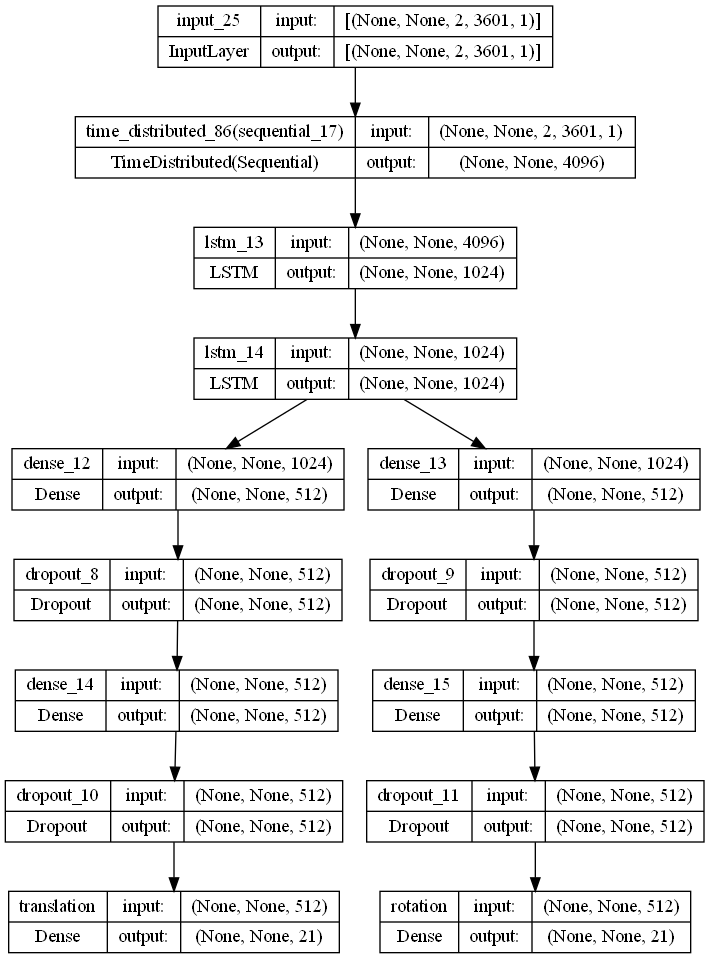

In [660]:
tf.keras.utils.plot_model(pre_model, show_shapes=True)

In [661]:
# train_data, val_data, test_data
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

True

In [662]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [663]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 768312961296966706
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 5748293632
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 10621078982769235340
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

# Tek sequence eğitimi

In [664]:
pre_model.output

[<KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None, 21]), tf.float32, 1, tf.int64) (created by layer 'translation')>,
 <KerasTensor: type_spec=RaggedTensorSpec(TensorShape([None, None, 21]), tf.float32, 1, tf.int64) (created by layer 'rotation')>]

In [665]:
pre_model.fit(train_data,
              epochs=50,
              validation_data=val_data,
              verbose=1
              #validation_steps=int(0.25 * len(val_data))
              #callbacks=[create_tensorboard_callback("transfer_learning", "10_percent_feature_ext")]
             )

Epoch 1/50


ValueError: in user code:

    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\filiz\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_2" is incompatible with the layer: expected shape=(None, None, 2, 3601, 1), found shape=(None, 2, 3601, 1)


In [412]:
predictions = pre_model.predict(test_data)

6/6 [==============================] - 0s 59ms/step


In [413]:
prediction_train = pre_model.predict(train_data)

25/25 [==============================] - 0s 8ms/step


# Eğitilen tüm veriler için

In [414]:
X_train = list(map(lambda x: x[0], train_data))
y_train = list (map(lambda x: x[1], train_data))

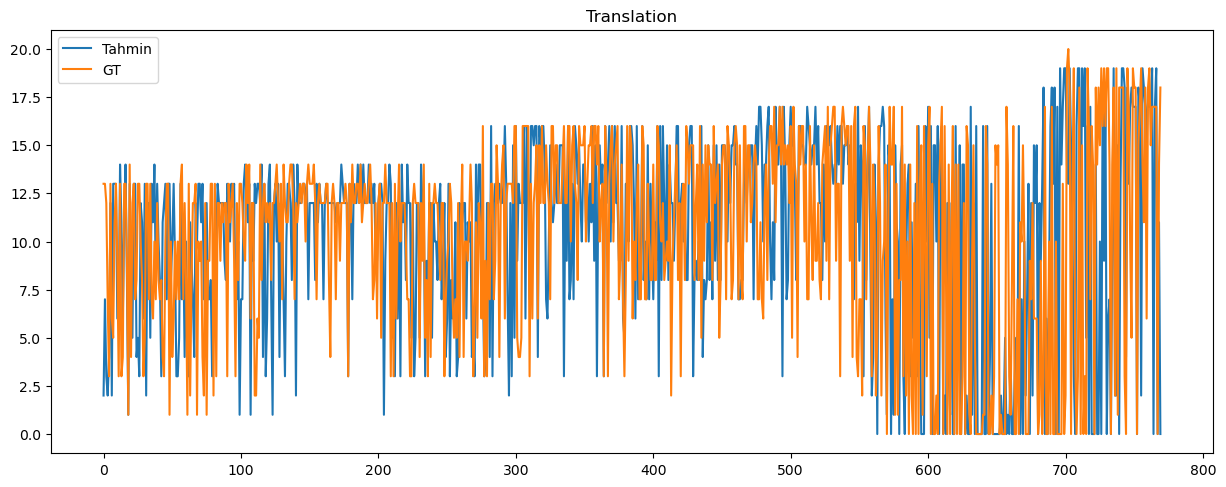

In [433]:
plt.plot(np.argmax(prediction_train[0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_train], axis=0), axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

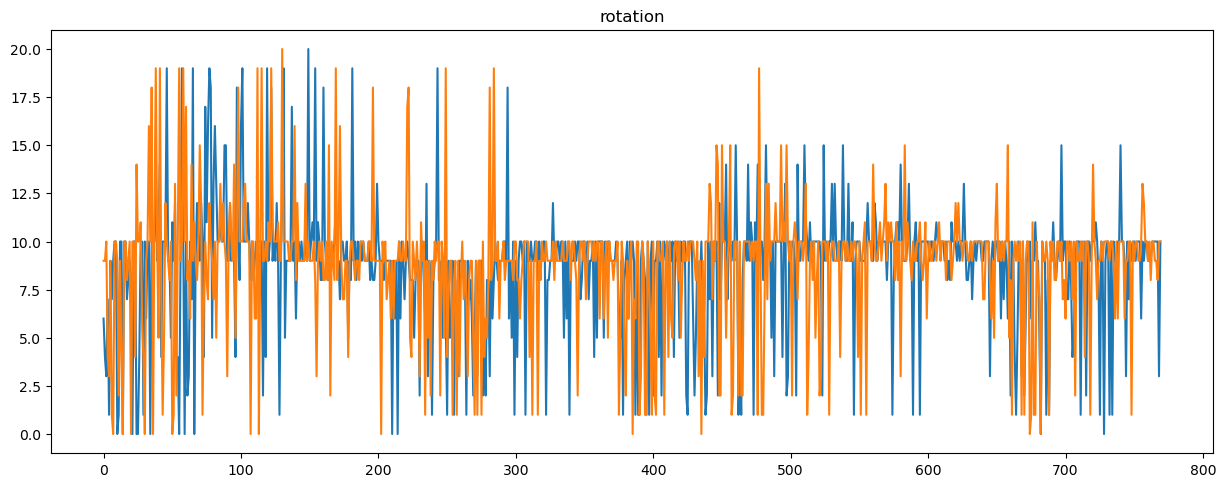

In [435]:
plt.plot(np.argmax(prediction_train[1], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_train], axis=0), axis=1), label="GT")


plt.title("Rotation")
plt.show()

In [437]:
X_test = list(map(lambda x: x[0], test_data))
y_test = list(map(lambda x: x[1], test_data))

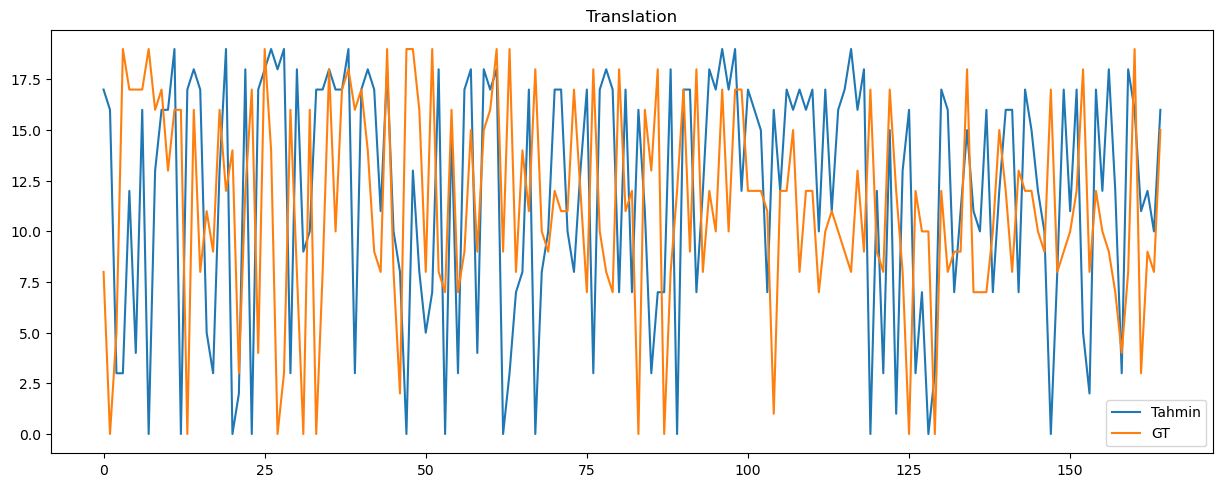

In [438]:
plt.plot(np.argmax(predictions[0], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['translation'] for i in y_test], axis=0), axis=1), label="GT")

plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

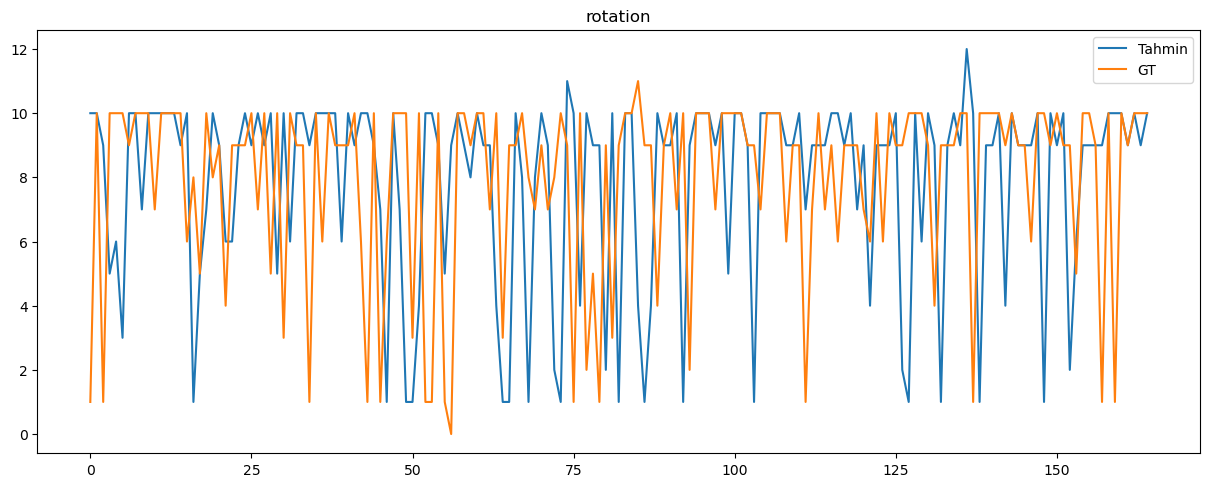

In [443]:
plt.plot(np.argmax(predictions[1], axis=1),label="Tahmin")
plt.plot(np.argmax(tf.concat([i['rotation'] for i in y_test], axis=0), axis=1), label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

#  K-Fold CNN training

In [448]:
import numpy as np
import matplotlib.pyplot as plt
import pykitti
import math 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import tensorflow as tf
def readBinDataset(filename):
    binDataset = np.load(filename)
    #print(bin)

    return binDataset

In [449]:
total_dataset_sz = 11
binDataset_ = []

In [450]:
#windows
for sequence in range(total_dataset_sz):
    binDataset_.append(readBinDataset(r"D:\Ara\numpy_dataset_sequences\%02d_angleBin.npy" % sequence))
    binDataset_[sequence]=binDataset_[sequence].reshape((len(binDataset_[sequence]), 3601,1 ))
    binDataset_[sequence] = np.array([ consec_frames for consec_frames in zip(binDataset_[sequence][0::], binDataset_[sequence][1::])])

# linux
#binDataset=readBinDataset("/mnt/d/Ara/numpy_dataset_sequences/%02d_angleBin.npy" % sequence)

In [451]:
binDataset_

[array([[[[ 0.        ],
          [ 0.        ],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],
 
         [[ 0.        ],
          [ 0.        ],
          [73.48016344],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]]],
 
 
        [[[ 0.        ],
          [ 0.        ],
          [73.48016344],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],
 
         [[72.76693954],
          [ 0.        ],
          [72.6450026 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]]],
 
 
        [[[72.76693954],
          [ 0.        ],
          [72.6450026 ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [ 0.        ]],
 
         [[71.92894222],
          [71.98888199],
          [ 0.        ],
          ...,
          [ 0.        ],
          [ 0.        ],
          [72.

In [452]:
binDataset_[sequence].shape

(1200, 2, 3601, 1)

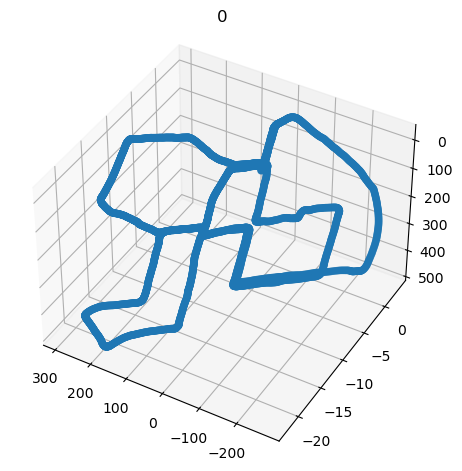

<Figure size 1500x550 with 0 Axes>

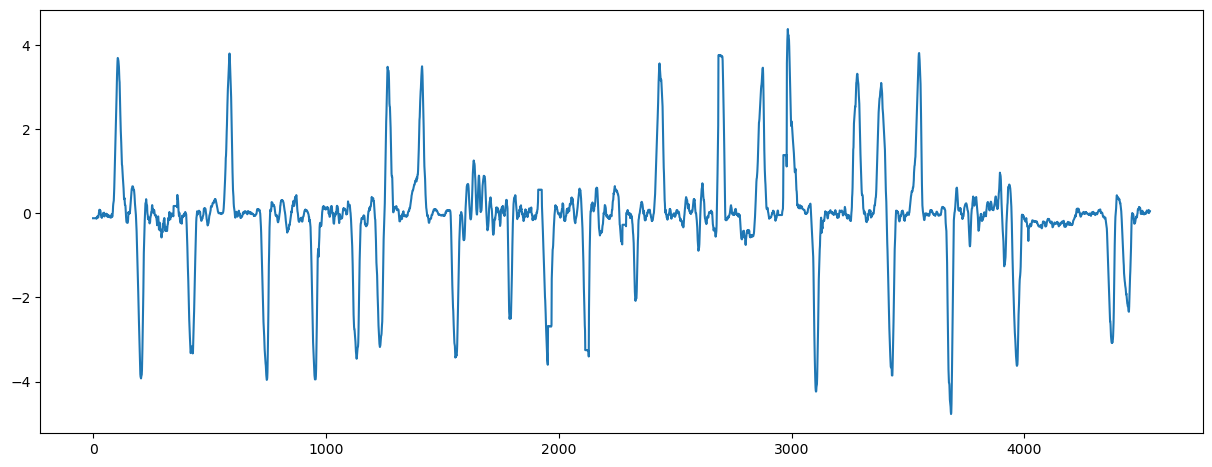

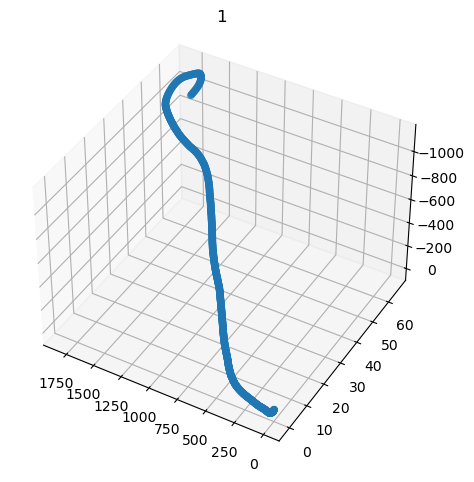

<Figure size 1500x550 with 0 Axes>

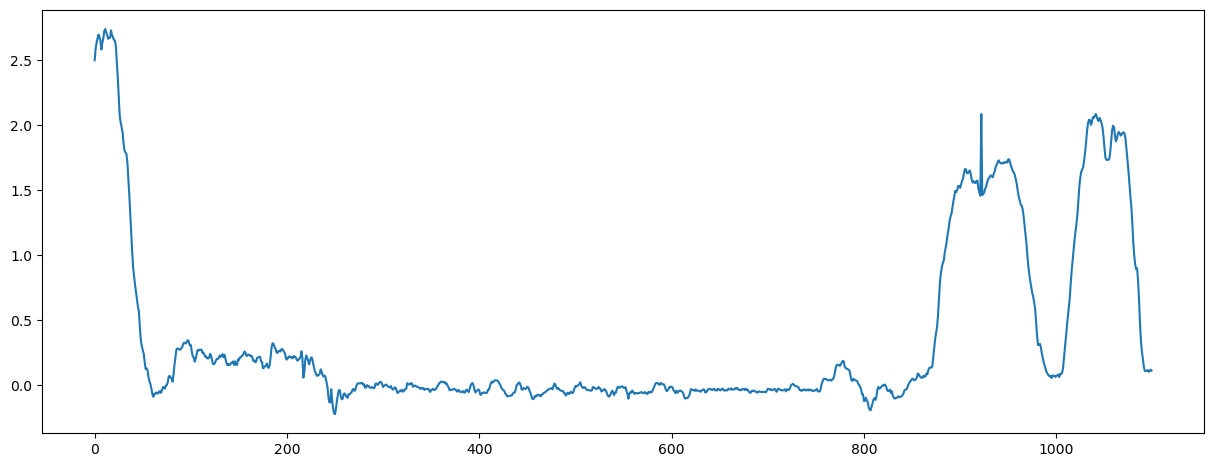

<Figure size 1500x550 with 0 Axes>

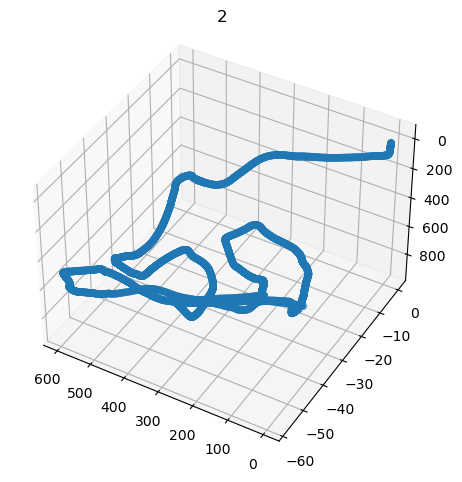

<Figure size 1500x550 with 0 Axes>

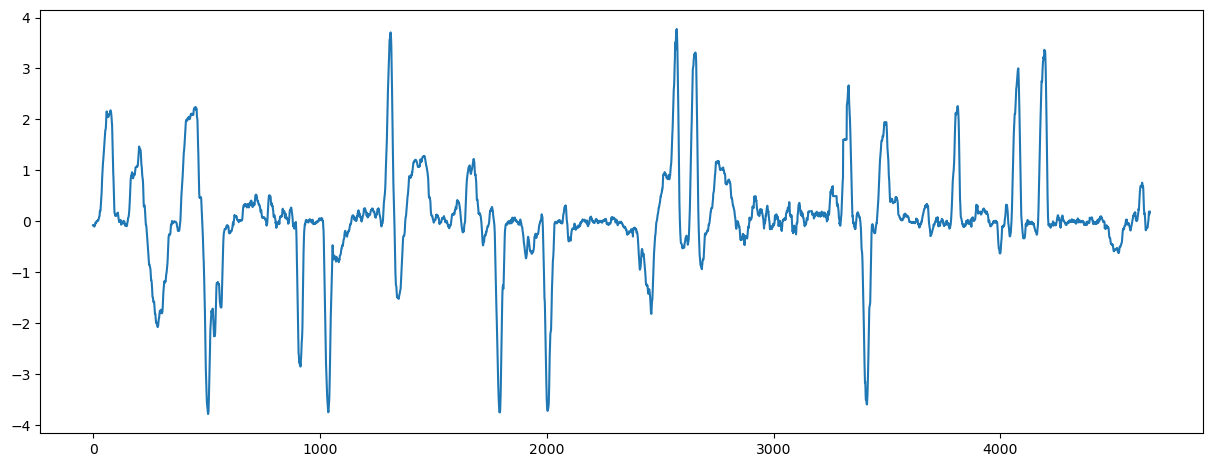

<Figure size 1500x550 with 0 Axes>

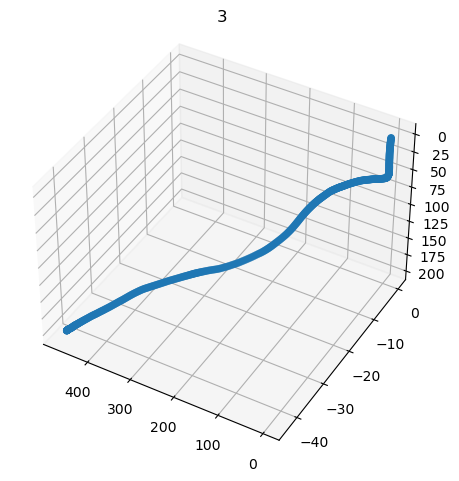

<Figure size 1500x550 with 0 Axes>

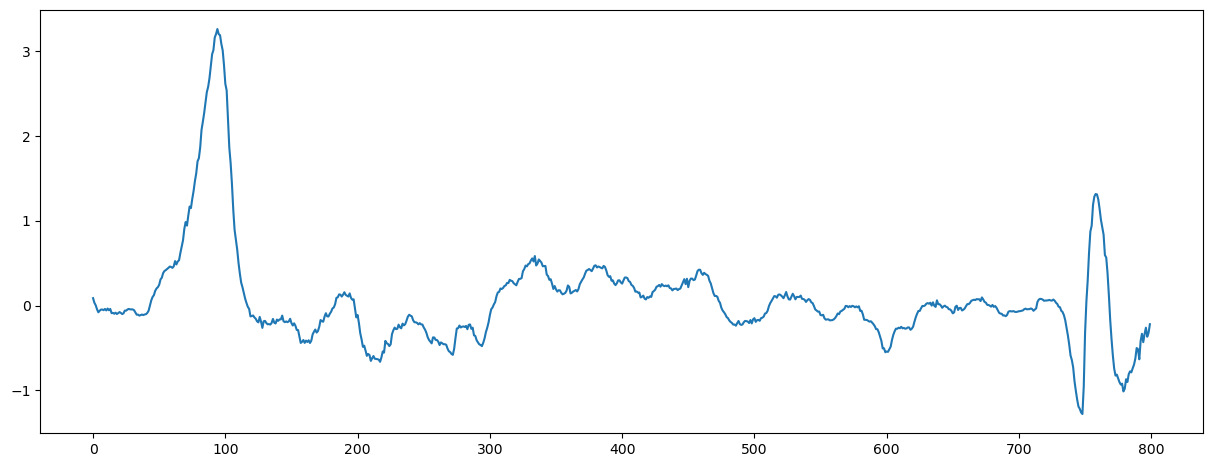

<Figure size 1500x550 with 0 Axes>

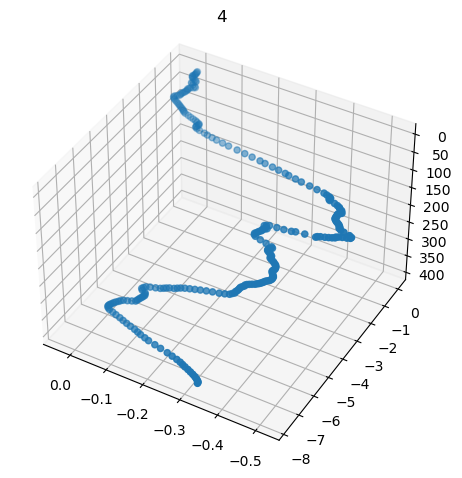

<Figure size 1500x550 with 0 Axes>

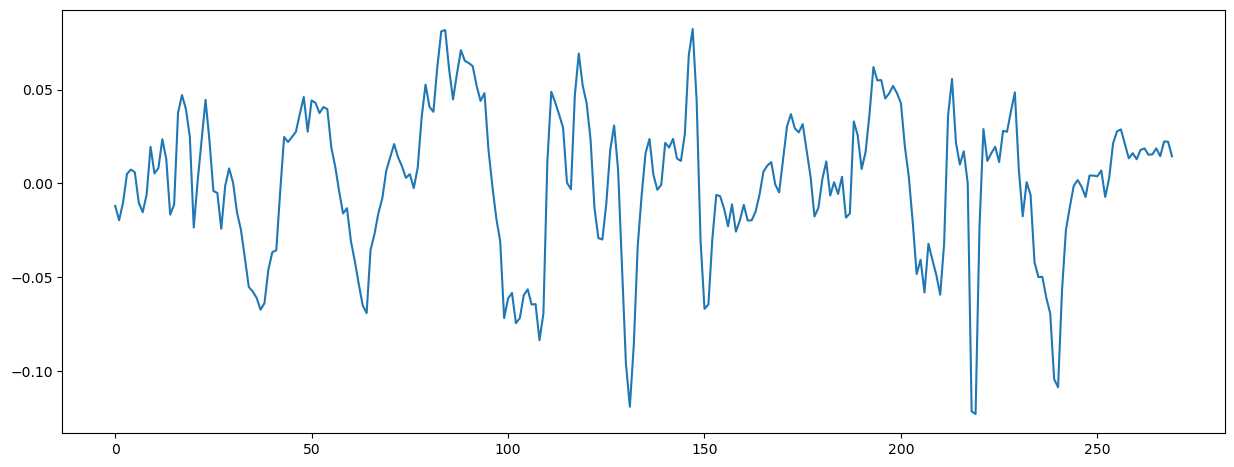

<Figure size 1500x550 with 0 Axes>

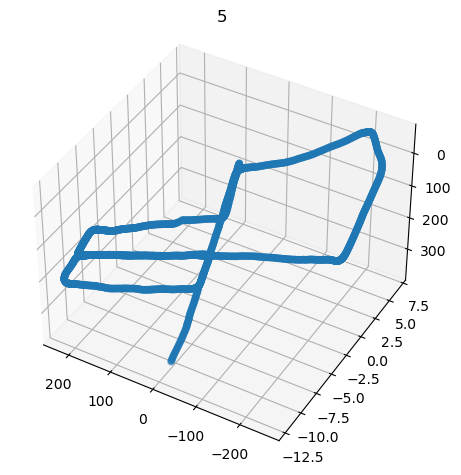

<Figure size 1500x550 with 0 Axes>

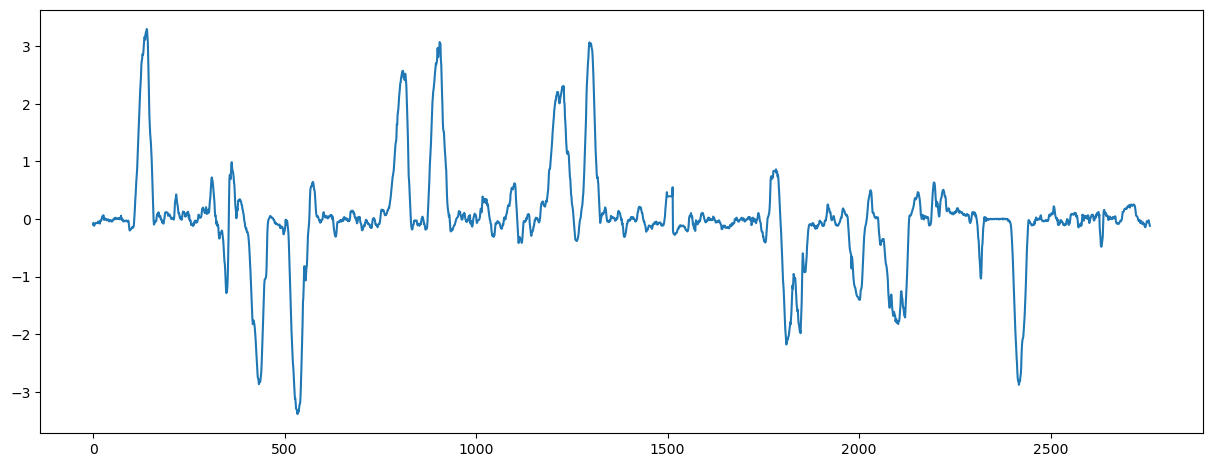

<Figure size 1500x550 with 0 Axes>

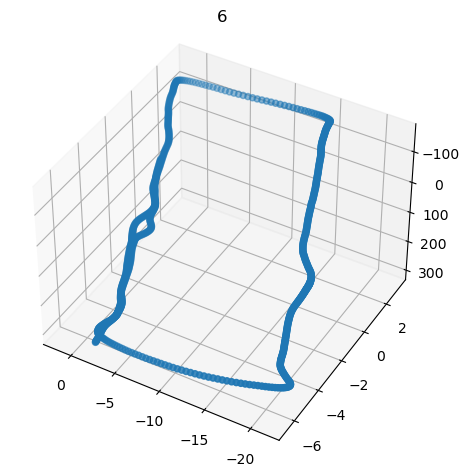

<Figure size 1500x550 with 0 Axes>

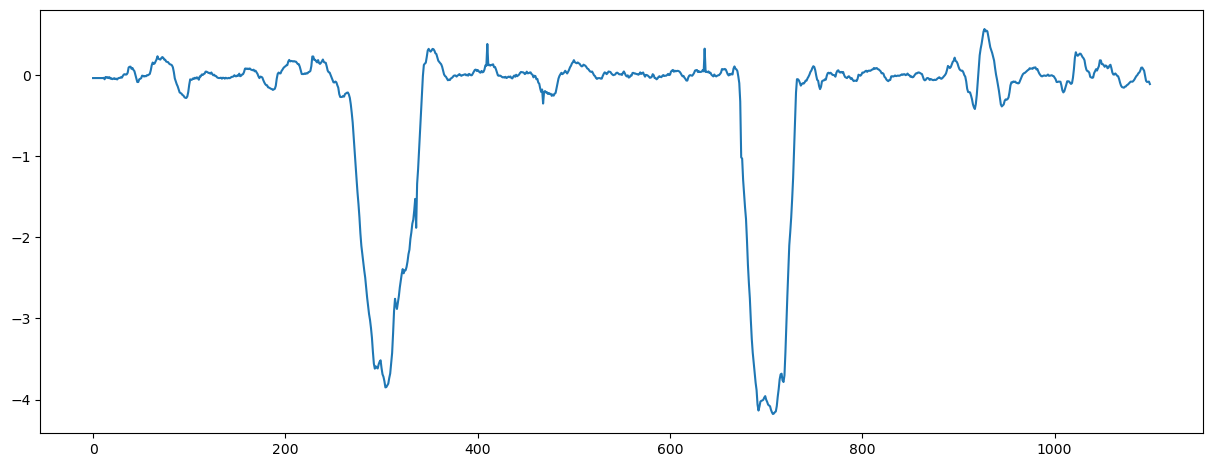

<Figure size 1500x550 with 0 Axes>

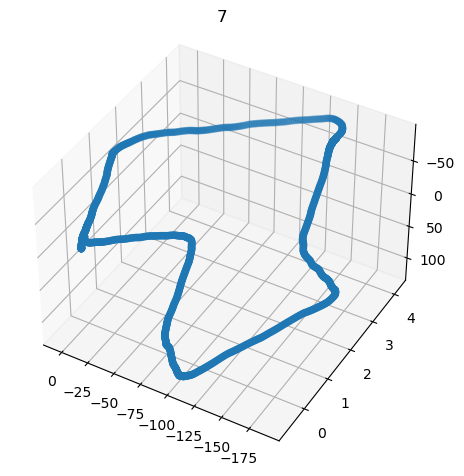

<Figure size 1500x550 with 0 Axes>

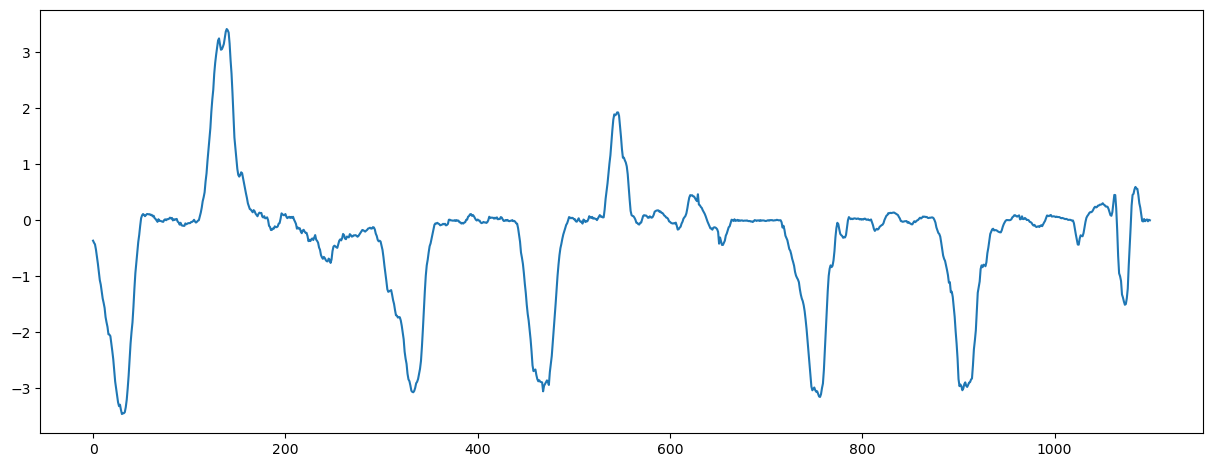

<Figure size 1500x550 with 0 Axes>

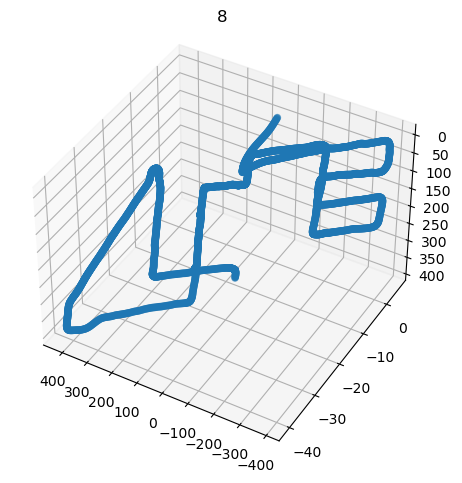

<Figure size 1500x550 with 0 Axes>

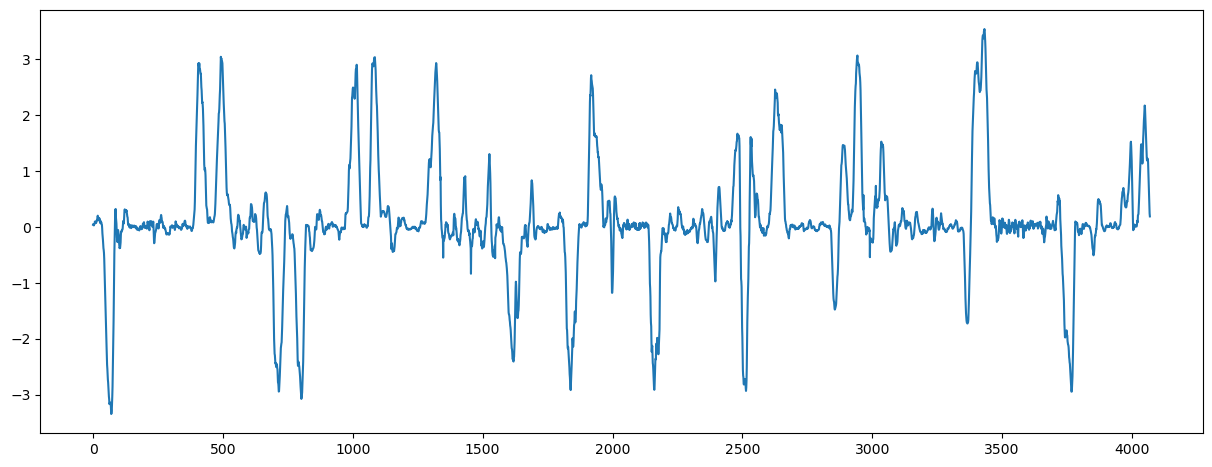

<Figure size 1500x550 with 0 Axes>

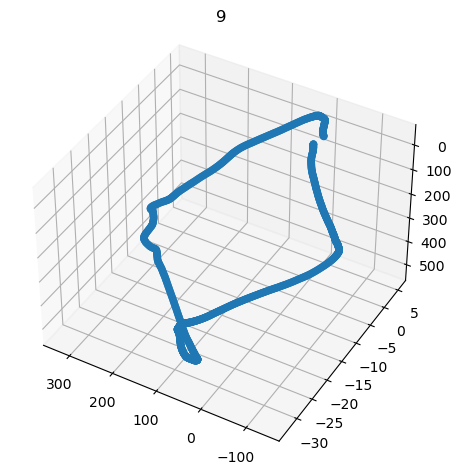

<Figure size 1500x550 with 0 Axes>

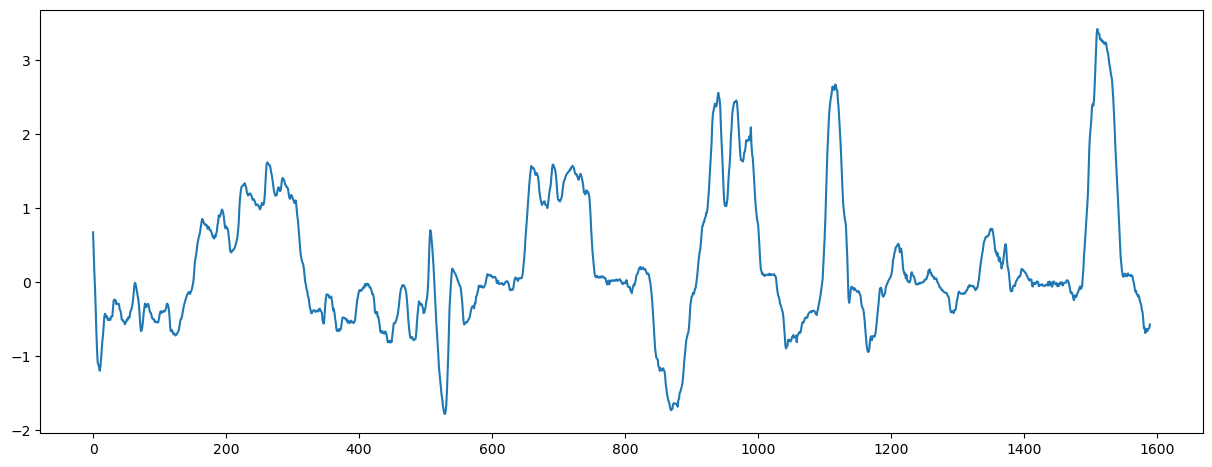

<Figure size 1500x550 with 0 Axes>

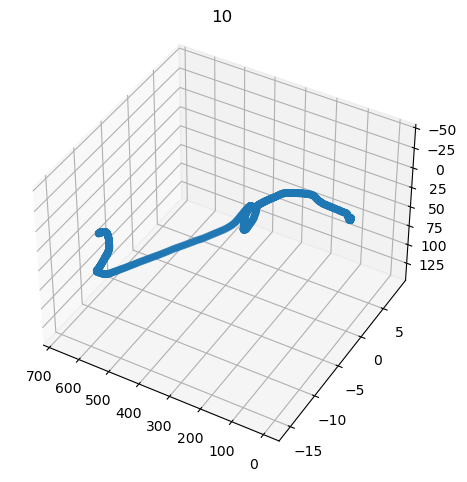

<Figure size 1500x550 with 0 Axes>

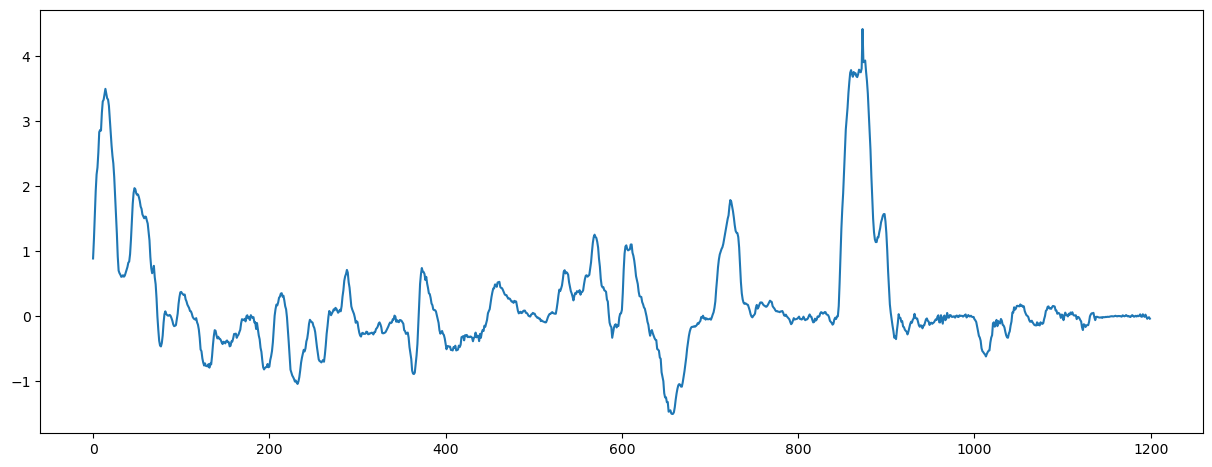

<Figure size 1500x550 with 0 Axes>

In [453]:
label_ = []
for sequence in range(total_dataset_sz):
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

    fig = plt.figure(sequence)
    ax = fig.add_subplot(projection='3d' )
    ax.set_title(str(sequence))
    for i in range(len(dataset.poses)):
        x=np.append(x, [dataset.poses[i][0][3]])
        y=np.append(y, [dataset.poses[i][1][3]])
        z=np.append(z, [dataset.poses[i][2][3]])

    ax.scatter(x, y, z, marker='o')
    
    ax.view_init(-140, 60)
    plt.pause(0.1)
    plt.clf()

    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    fig1 = plt.figure()
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    
    plt.plot((np.rad2deg(diff_pitch_)))
    plt.pause(0.001)
    plt.clf()
#     plt.ylim([-4, 4])
#     plt.show()

In [454]:
len(binDataset_[3][0][1])

3601

In [455]:
binDataset_[0].shape, label_[0].shape

((4540, 2, 3601, 1), (4540, 2))

In [456]:
binDataset_ = np.array(binDataset_)
label_ = np.array(label_)

C:\Users\filiz\AppData\Local\Temp\ipykernel_16000\4136154583.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  binDataset_ = np.array(binDataset_)
C:\Users\filiz\AppData\Local\Temp\ipykernel_16000\4136154583.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  label_ = np.array(label_)


In [457]:
from sklearn.model_selection import KFold

In [458]:
num_folds = len(binDataset_)

In [459]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

verbosity = 1
no_epochs = 10
batch_size = 4

In [460]:
from keras import backend as K
import keras

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
        for k, initializer in layer.__dict__.items():
            if "initializer" not in k:
                continue
            # find the corresponding variable
            var = getattr(layer, k.replace("_initializer", ""))
            var.assign(initializer(var.shape, var.dtype))

In [461]:
reset_weights(pre_model)
keras.backend.clear_session()

c:\Users\filiz\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [462]:
fold_no = 1

In [463]:
acc_per_fold = []

In [464]:
loss_per_fold = []

In [465]:
def plotAngleBin(ax,angleBin):
    
    ax.scatter(0,0)
    xList = []
    yList = []
    for angle, bin in enumerate(angleBin):
        if bin > 0:
            y=bin*np.sin(np.deg2rad(angle*0.1))
            x=bin*np.cos(np.deg2rad(angle*0.1))
            xList.append(x)
            yList.append(y)
            # ax.scatter(x,y)
    ax.scatter(xList,yList)
    plt.pause(0.00000000000001)
    plt.show()

In [466]:
for train, test in kfold.split(binDataset_, label_):
    train_data_ = np.concatenate(binDataset_[train], axis=0)
    train_label_ = np.concatenate(label_[train], axis=0)
    
    dataset_ = tf.data.Dataset.from_tensor_slices((train_data_, train_label_))
    full_dataset_ = dataset_.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
batch = full_dataset_.as_numpy_iterator()

In [ ]:
batch_ = batch.next()

In [149]:
train_data_[0].shape, binDataset_[0].shape, batch_[0].shape batch_[1].shape

((2, 3601, 1), (4540, 2, 3601, 1), (4, 2, 3601, 1))

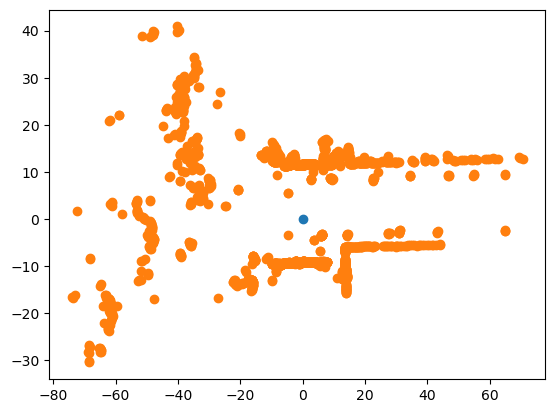

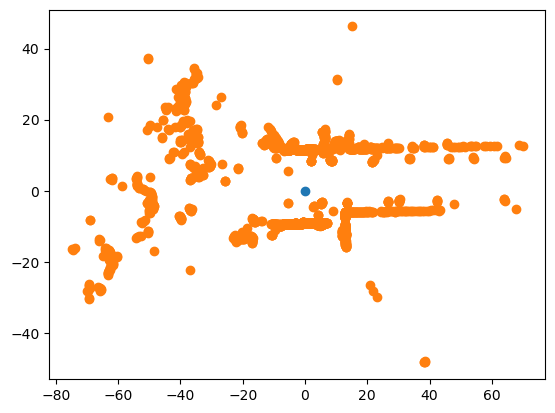

In [151]:
ax = plt.axes()


plotAngleBin(ax,batch_[0][0][0])

ax2 = plt.axes()

plotAngleBin(ax2,batch_[0][0][1])


In [79]:
np.count_nonzero( train_data_[20][0] == train_data_[20][1] )

869

In [59]:
for train, test in kfold.split(binDataset_, label_):
    
    
    train_data_ = np.concatenate(binDataset_[train], axis=0)
    train_label_ = np.concatenate(label_[train], axis=0)
    dataset_ = tf.data.Dataset.from_tensor_slices((train_data_, train_label_))
    full_dataset_ = dataset_.shuffle(buffer_size=100).batch(batch_size=batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

    history=pre_model.fit(full_dataset_,
              epochs=no_epochs,
              verbose=verbosity)
    
    
    test_data_ = np.concatenate(binDataset_[test], axis=0)
    test_label_ = np.concatenate(label_[test], axis=0)
    # Generate generalization metrics
    scores = pre_model.evaluate(test_data_, test_label_, verbose=0)
    print(f'Score for fold {fold_no}: {pre_model.metrics_names[0]} of {scores[0]}; {pre_model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    break

KeyboardInterrupt: 

In [118]:
fold_no

2

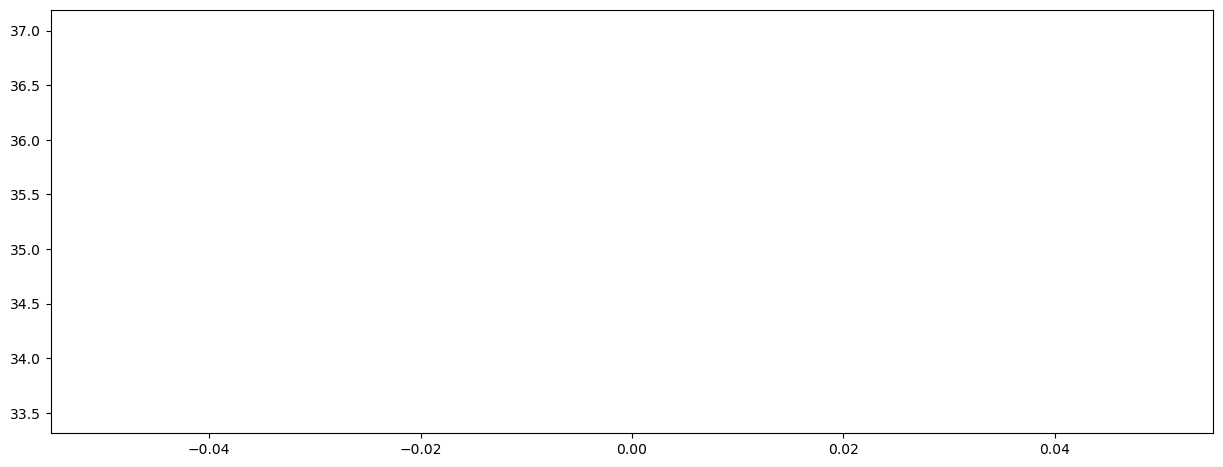

In [119]:
plt.plot(acc_per_fold)

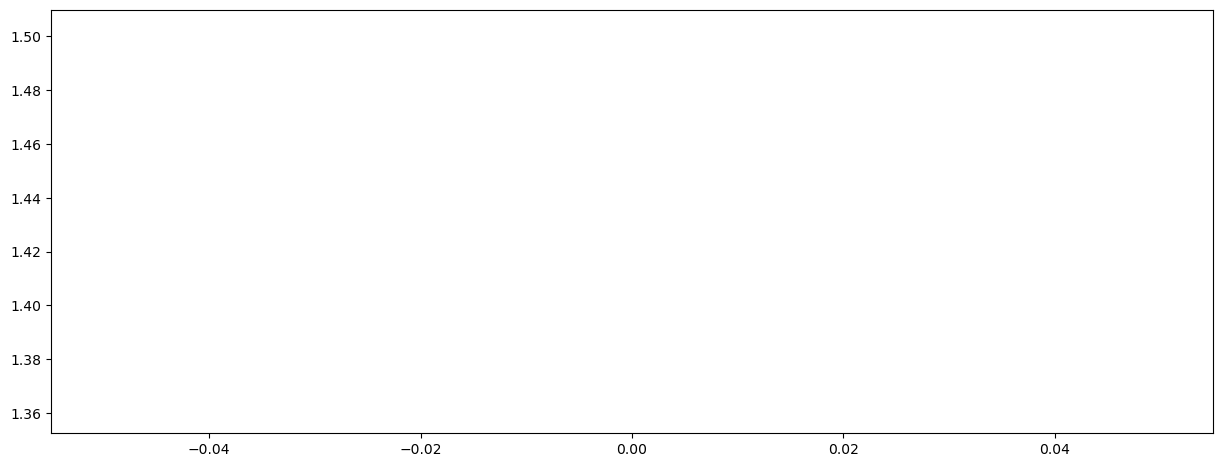

In [120]:
plt.plot(loss_per_fold)

# Tek tek değerlendir

In [81]:
X_train = list(map(lambda x: x[0], train_data))
y_train = list (map(lambda x: x[1], train_data))

NameError: name 'train_data' is not defined

In [122]:
predictions = pre_model.predict(test_data)
prediction_train = pre_model.predict(train_data)

193/193 [==============================] - 1s 5ms/step


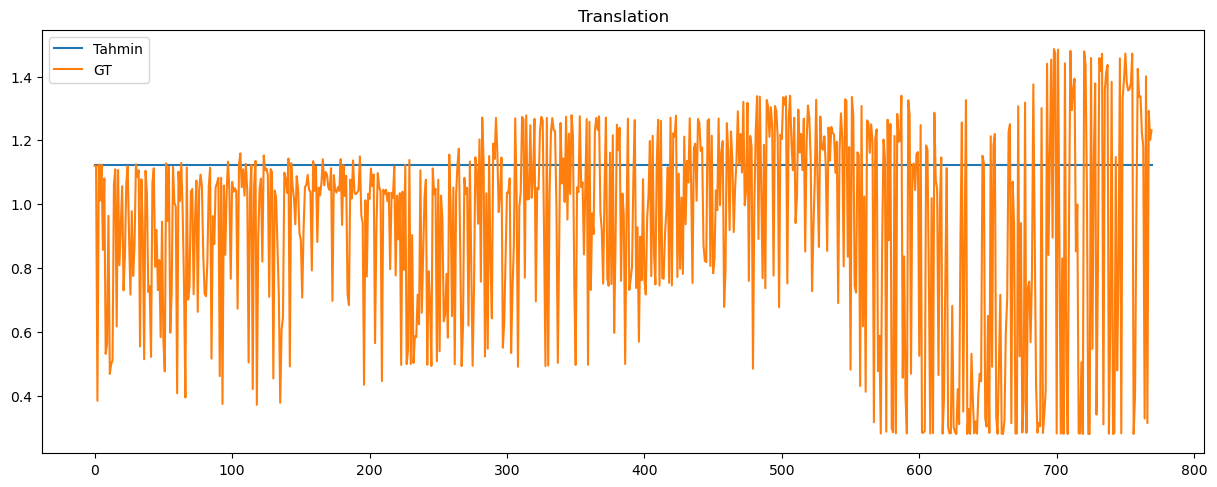

In [123]:
plt.plot(prediction_train[0], label="Tahmin")
plt.plot(tf.concat(y_train,0)[:,0], label="GT")
plt.title("Translation")
#plt.xlim([0,50])

plt.legend()
plt.show()

NameError: name 'y_train' is not defined

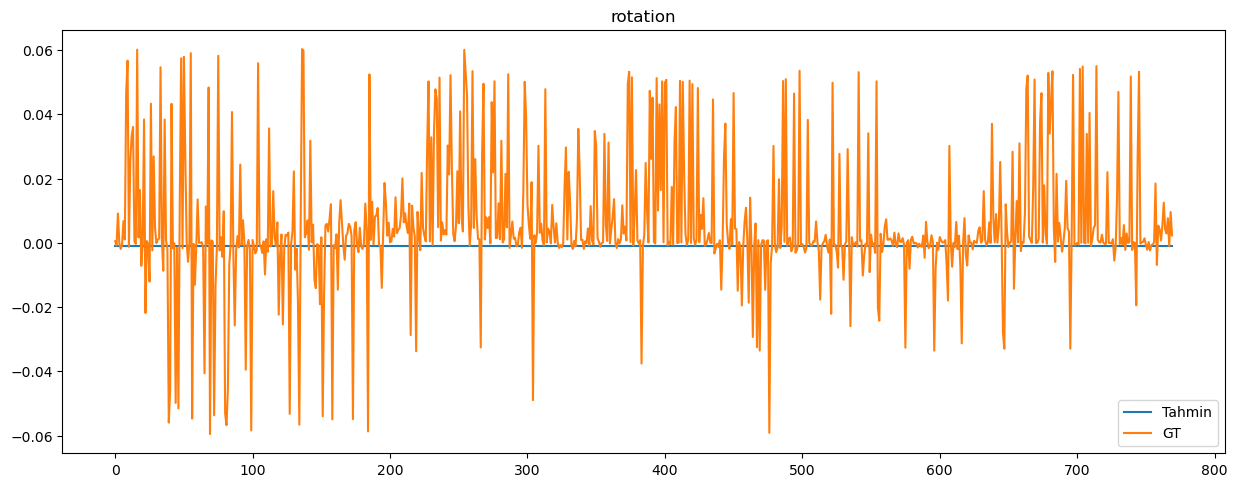

In [124]:
plt.plot(prediction_train[1], label="Tahmin")
plt.plot(tf.concat(y_train,0)[:,1], label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

In [125]:
X_test = list(map(lambda x: x[0], test_data))
y_test = list(map(lambda x: x[1], test_data))

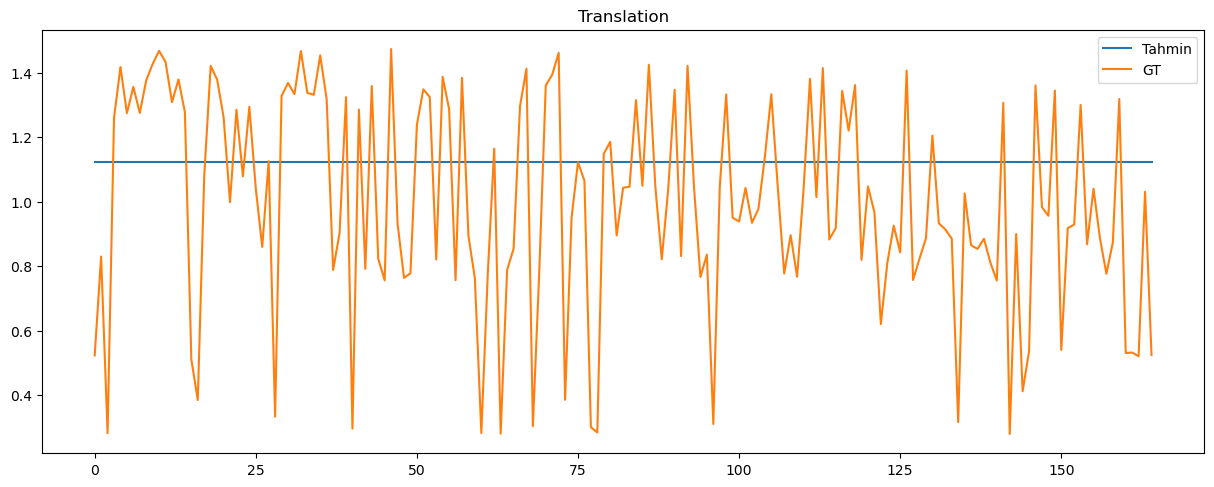

In [126]:
plt.plot(predictions[0],label="Tahmin")
plt.plot(tf.concat(y_test,0)[:,0], label="GT")
plt.title("Translation")
plt.legend()
#plt.xlim([0,10])
plt.show()

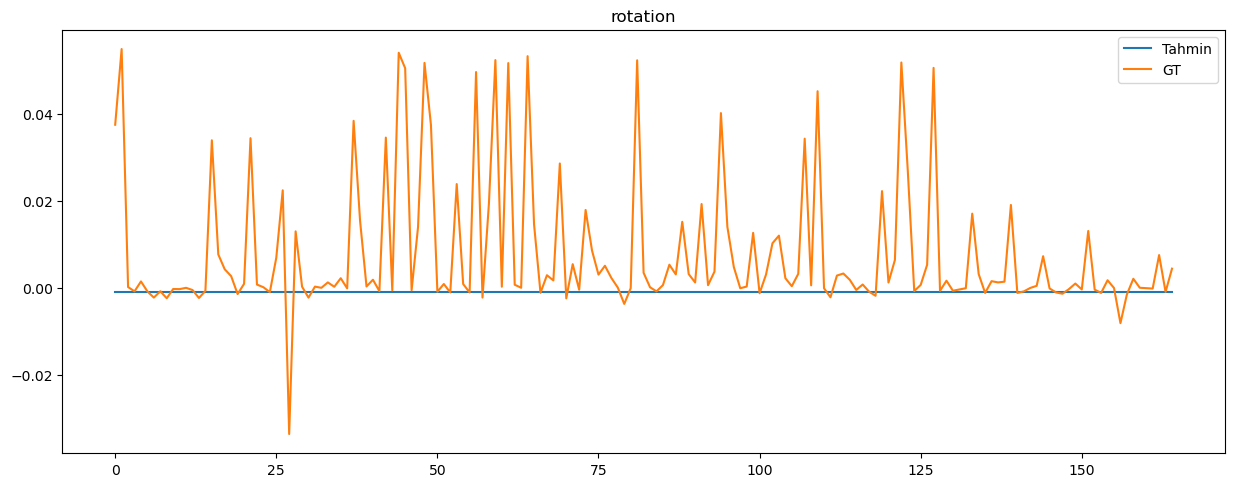

In [127]:
plt.plot(predictions[1], label="Tahmin")
plt.plot(tf.concat(y_test,0)[:,1], label="GT")
plt.legend()
#plt.xlim([0,10])
plt.title("rotation")
plt.show()

# Example CNN LSTM architecture

CNN Model

In [1]:
import tensorflow as tf

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate
from keras.layers import TimeDistributed
from keras.layers import LSTM

In [547]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [548]:
from numpy import zeros, array
from random import randint
from random import random
from matplotlib import pyplot

# generate the next frame in the sequence
def next_frame(last_step, last_frame, column):
    # define the scope of the next step
    lower = max(0, last_step-1)
    upper = min(last_frame.shape[0]-1, last_step+1)
    # choose the row index for the next step
    step = randint(lower, upper)
    # copy the prior frame
    frame = last_frame.copy()
    # add the new step
    frame[step, column] = 1
    return frame, step
# generate a sequence of frames of a dot moving across an image
def build_frames(size):
    frames = list()
    # create the first frame
    frame = zeros((size,size))
    step = randint(0, size-1)
    # decide if we are heading left or right
    right = 1 if random() < 0.5 else 0
    col = 0 if right else size-1
    frame[step, col] = 1
    frames.append(frame)
    # create all remaining frames
    for i in range(1, size):
        col = i if right else size-1-i
        frame, step = next_frame(step, frame, col)
        frames.append(frame)
    return frames, right



In [549]:
# generate sequence of frames
size = 5
frames, right = build_frames(size)

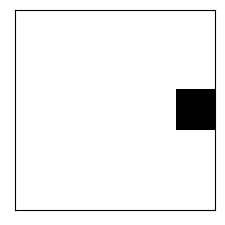

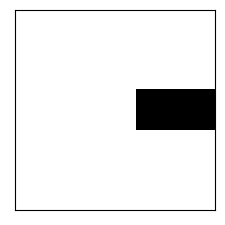

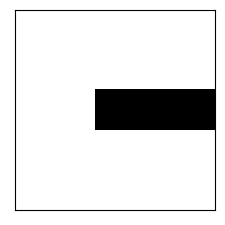

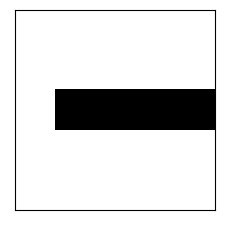

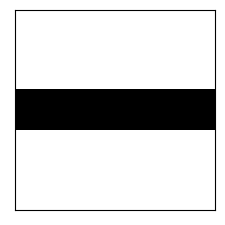

In [550]:
# plot all feames
pyplot.figure()
for i in range(size):
    # create a grayscale subplot for each frame
    pyplot.subplot(1, size, i+1)
    pyplot.imshow(frames[i], cmap= 'Greys' )
    # turn of the scale to make it cleaer
    ax = pyplot.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # show the plot
    pyplot.show()

Generate Dataset

In [551]:
# generate multiple sequences of frames and reshape for network input
def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
    # resize as [samples, timesteps, width, height, channels]
    X = array(X).reshape(n_patterns, size, size, size, 1)
    y = array(y).reshape(n_patterns, 1)
    return X, y

# Model

define the model


In [552]:
# configure problem
size = 50
# define the model
model = Sequential()
model.add(TimeDistributed(Conv2D(2, (2,2), activation= 'relu' ),
input_shape=(None,size,size,1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation= 'sigmoid' ))
model.compile(loss= 'binary_crossentropy' , optimizer= 'adam' , metrics=[ 'acc' ])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_46 (TimeDi  (None, None, 49, 49, 2)  10        
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, None, 24, 24, 2)  0         
 stributed)                                                      
                                                                 
 time_distributed_48 (TimeDi  (None, None, 1152)       0         
 stributed)                                                      
                                                                 
 lstm_2 (LSTM)               (None, 50)                240600    
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                      

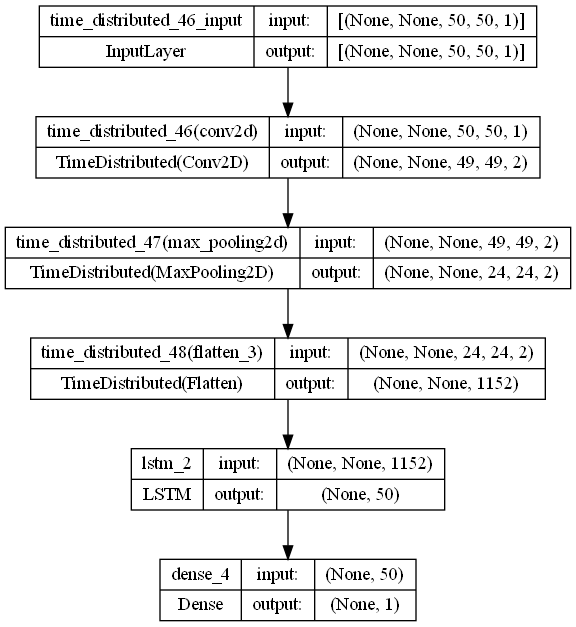

In [553]:
tf.keras.utils.plot_model(model, show_shapes=True)

fit model

In [11]:
X, y = generate_examples(size, 5000)
model.fit(X, y, batch_size=32, epochs=1)

157/157 [==============================] - 35s 37ms/step - loss: 0.3232 - acc: 0.9018


evaluate model

In [12]:
y

array([[1],
       [1],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [16]:
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print( "loss: %f, acc: %f " % (loss, acc*100))

loss: 0.012066, acc: 100.000000 


prediction on new data

In [18]:
X, y = generate_examples(size, 1)
# yhat = model.predict_classes(X, verbose=0)
yhat = (model.predict(X) > 0.5).astype("int32")
expected = "Right" if y[0]==1 else "Left"
predicted = "Right" if yhat[0]==1 else "Left"
print( "Expected: %s, Predicted: %s" % (expected, predicted) )

1/1 [==============================] - 1s 612ms/step
Expected: Left, Predicted: Left


Image Initialization

In [7]:
from numpy import zeros
frame = zeros((10,10))

In [8]:
from random import randint
step = randint(0, 10-1)

In [ ]:
from random import random
right = 1 if random() < 0.5 else 0
col = 0 if right else 9

In [ ]:
frame[step, col] = 1

Adding Steps

In [6]:
lower = max(0, last_step-1)
upper = min(10-1, last_step+1)
step = randint(lower, upper)


In [ ]:
column = i if right else size-1-i
frame = last_frame.copy()
frame[step, column] = 1

# tüm labelları oku ve min max scaling yap

minimum ve maksimum labellı verileri tüm veri seti içerisinden bul.

In [7]:
import pykitti
import numpy as np
total_dataset_sz = 11

In [8]:
for sequence in range(total_dataset_sz):
    basedir = 'D:\\dataset\\'
    sequence_ = '%02d' % sequence
    dataset = pykitti.odometry(basedir, sequence_)
    
   
    x=np.array([])
    y=np.array([])
    z=np.array([])
    yaw=np.array([])

 
    t_xyz = np.c_[x, y, z]
    dt_xyz = t_xyz[1:] - t_xyz[0:-1]
    dt_xz = dt_xyz[:,[0,2]]
    translation_ = np.sqrt( dt_xz[:,0]** 2 +  dt_xz[:,1]**2)

    translation_ += 0.28 
    
    
    
    yaw_=np.zeros(len(dataset.poses))
    for i in range(len(dataset.poses)):
        r= R.from_matrix([[dataset.poses[i][0][0], dataset.poses[i][0][1], dataset.poses[i][0][2]], [dataset.poses[i][1][0], dataset.poses[i][1][1], dataset.poses[i][1][2]], [dataset.poses[i][2][0], dataset.poses[i][2][1], dataset.poses[i][2][2]]])
        yaw=-r.as_rotvec()[1]
        yaw_[i]=yaw
    # plt.plot(np.rad2deg(yaw_))

    diff_pitch_ = -(yaw_[1::]-yaw_[:-1:])

    # outlier detection
    idxs = np.where((diff_pitch_>np.deg2rad(300)) | (diff_pitch_<np.deg2rad(-300)))

    diff_pitch_[idxs] =  diff_pitch_[idxs] - np.deg2rad(360)  * np.sign(diff_pitch_[idxs])

    label_.append(np.transpose(np.array((translation_,diff_pitch_))))
    


NameError: name 'R' is not defined

In [ ]:
binDataset_[0].shape, label_[0].shape

# classificationa örnekle

In [135]:
from time import time
import numpy as np
import matplotlib.pyplot as plt


# Odometri Sonucunu Çizdir

# Modeli Ubuntuya Göndermek İçin Kaydet

# Laser verisini gazebodan al

# Laser verisini kutula ve modele değerlendirme olarak at

# Çıkan sonuçtan artımlı odometri çiz

# Deterministik Modeli Kur ve Karşılaştır